In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random

In [23]:
from keras.preprocessing.image import ImageDataGenerator

In [35]:
path = "main signs"  # folder with all the class folders
labelFile = 'labels.csv'  # file with all names of classes
batch_size_val = 50  # how many to process together
steps_per_epoch_val = 20
epochs_val = 10
imageDimesions = (32, 32, 3)
testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation

In [36]:
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:",len(myList)-1)
noOfClasses=len(myList)-1
print("Importing Classes.....")
for x in range (0,noOfClasses):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")

Total Classes Detected: 4
Importing Classes.....
0 1 2 3  


In [37]:
images = np.array(images)
classNo = np.array(classNo)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)

Data Shapes
Train(1746, 32, 32, 3) (1746,)
Validation(437, 32, 32, 3) (437,)
Test(546, 32, 32, 3) (546,)


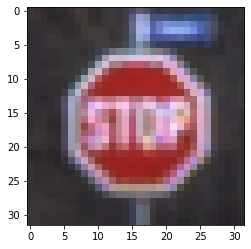

In [39]:
plt.imshow(images[40])

In [40]:
classNo[40]

0

In [41]:
data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


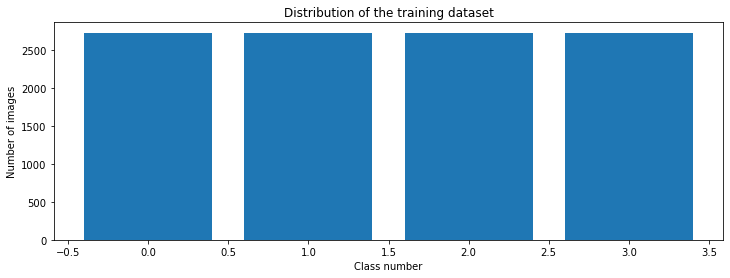

In [42]:
num_classes = noOfClasses
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), images.shape[0])
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [43]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)  # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img / 255  # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img

In [44]:
X_train = np.array(list(map(preprocessing, X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

In [45]:
X_train = X_train.reshape(X_train.shape [0],X_train.shape[1],X_train.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape [0],X_validation.shape[1],X_validation.shape[2],1)
X_test = X_test.reshape(X_test.shape [0],X_test.shape[1],X_test.shape[2],1)

In [46]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES
dataGen.fit(X_train)

batches = dataGen.flow(X_train, y_train,
                   batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

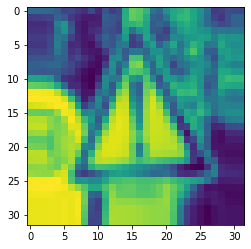

In [47]:
plt.imshow(X_batch[0].reshape(imageDimesions[0],imageDimesions[1]))

In [48]:
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [49]:
def myModel():
    no_Of_Filters = 60
    size_of_Filter = (5, 5)  # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
    # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500  # NO. OF NODES IN HIDDEN LAYERS
    model = Sequential()
    model.add((Conv2D(no_Of_Filters, size_of_Filter, input_shape=(imageDimesions [0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))  # DOES NOT EFFECT THE DEPTH/NO OF FILTERS
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation='relu'))
    model.add(Dropout(0.5))  # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses, activation='softmax'))  # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics= ['accuracy'])
    return model

In [50]:
model = myModel()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 30)         

In [51]:
history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),
                          steps_per_epoch=steps_per_epoch_val, epochs=epochs_val,
                          validation_data=(X_validation, y_validation), shuffle=1)


Epoch 1/10
20/20 [==============================] - 8s 362ms/step - loss: 1.3208 - accuracy: 0.3524 - val_loss: 0.9864 - val_accuracy: 0.6110
Epoch 2/10
20/20 [==============================] - 7s 358ms/step - loss: 0.9294 - accuracy: 0.6133 - val_loss: 0.2394 - val_accuracy: 0.9130
Epoch 3/10
20/20 [==============================] - 7s 342ms/step - loss: 0.5307 - accuracy: 0.8063 - val_loss: 0.0835 - val_accuracy: 0.9817
Epoch 4/10
20/20 [==============================] - 7s 347ms/step - loss: 0.3531 - accuracy: 0.8781 - val_loss: 0.0323 - val_accuracy: 0.9954
Epoch 5/10
20/20 [==============================] - 7s 348ms/step - loss: 0.2781 - accuracy: 0.9093 - val_loss: 0.0289 - val_accuracy: 0.9931
Epoch 6/10
20/20 [==============================] - 7s 346ms/step - loss: 0.3082 - accuracy: 0.9125 - val_loss: 0.0458 - val_accuracy: 0.9817
Epoch 7/10
20/20 [==============================] - 7s 342ms/step - loss: 0.2459 - accuracy: 0.9201 - val_loss: 0.0168 - val_accuracy: 0.9977
Epoch 

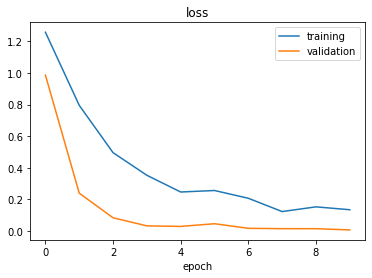

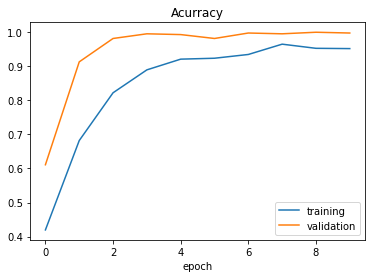

Test Score: 0.004468444734811783
Test Accuracy: 1.0


In [56]:
plt.figure(1)
plt.plot(history.history ['loss'])
plt.plot(history.history ['val_loss'])
plt.legend( ['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history ['accuracy'])
plt.plot(history.history ['val_accuracy'])
plt.legend( ['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score [0])
print('Test Accuracy:', score [1])

In [57]:
import joblib 

In [58]:
model.save('model.h5')

In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

In [2]:
frameWidth = 640  # CAMERA RESOLUTION
frameHeight = 480
brightness = 180
threshold = 0.75  # PROBABLITY THRESHOLD
font = cv2.FONT_HERSHEY_SIMPLEX

In [3]:
cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10, brightness)


True

In [4]:
model = load_model('model.h5')

In [5]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

In [6]:
def getCalssName(classNo):
    if classNo == 0:
        return 'Stop'
    elif classNo == 1:
        return 'Turn right ahead'
    elif classNo == 2:
        return 'Turn left ahead'
    elif classNo == 3:
        return 'Danger'

In [7]:
while True:

    # READ IMAGE
    success, imgOrignal = cap.read()

    # PROCESS IMAGE
    img = np.asarray(imgOrignal)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    cv2.imshow("Processed Image", img)
    img = img.reshape(1, 32, 32, 1)
    cv2.putText(imgOrignal, "CLASS: ", (20, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(imgOrignal, "PROBABILITY: ", (20, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    # PREDICT IMAGE
    predictions = model.predict(img)
    classIndex = model.predict_classes(img)
    probabilityValue = np.amax(predictions)
    if probabilityValue > threshold:
    # print(getCalssName(classIndex))
        cv2.putText(imgOrignal, str(classIndex) + " " + str(getCalssName(classIndex)), (120, 35), font, 0.75, (0, 0, 255), 2,cv2.LINE_AA)
        cv2.putText(imgOrignal, str(round(probabilityValue * 100, 2)) + "%", (180, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.imshow("Result", imgOrignal)

    if cv2.waitKey(1) and 0xFF == ord('q'):
        break

/home/etd/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


KeyboardInterrupt: 